# Theorie DB Scan

## Handige sites
https://www.sciencedirect.com/science/article/pii/S0957417417307698
https://www.sciencedirect.com/science/article/pii/S2352146518301820
https://www.sciencedirect.com/science/article/pii/S1877050915008741
https://github.com/turi-code/userguide/blob/master/clustering/dbscan.md

## uitleg
4 method for clustering:
     1. partitioning approaches (where the number of clusters is pre-assigned)
     2. grid-based (where the object space is divided into a pre-assigned number of cells)
     3. hierarchical (where the data is organized in multiple levels) 
     4. density-based (where density notion is considered).

DBScan is density-based. It needs two parameters:
     1. Radius of a circle around the data point
     2. Minimum number of points that should be in the circle
     
DBSCAN-TE is used to group GPS points into clusters (stopping points) and
noise (moving points) due to their difference in spatial density, temporal 
sequence, and entropy index. Activity stops are then refined from stopping 
points by SVMs. The structure of the two-step methodology is shown in Fig. 1.

## Installeren programma's 
Install geopandas, GDAL, Fiona, Basemap, Shapely, Pyproj, wheel -->link voor downloads https://www.lfd.uci.edu/~gohlke/pythonlibs/

Bestand van download naar script map anaconda --> pip install bestand.whl (behalve bij geopandas, deze moet je installeren via GitHub)

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

#inladen csv (uitkomst vorige script)
df = pd.read_csv('XYT_speed_distance.csv')
df = df[:-1]
df_old = df

#Verwijder punten die boven de 1 km per uur zitten, want dit zijn sws geen stoplocaties)
df = df.drop(df[df.speed_kmu > 1].index)
coords = np.asarray(df[['Lat_a', 'Lon_a']])

C:\Users\candy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


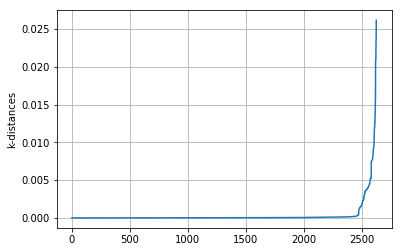

In [10]:
#bereken EPS door te kijken wat de afstand is tussen punten (onder 1 kmu)
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm
m, m2= k_distances2(coords, 5)
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

In [11]:
#Berekenen de clusters (bereken afstand tussen twee XY punten)
kms_per_radian = 6371.0088
m_per_radian = 6371008.8
epsilon = 0.005 / kms_per_radian
epsilon_m = 5 / m_per_radian #5 meter kwam uit k_distance
db = DBSCAN(eps=epsilon_m, min_samples=4, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print('Number of clusters: {}'.format(num_clusters))

#Clusterlabels naar column
df["cluster"] = cluster_labels

Number of clusters: 22


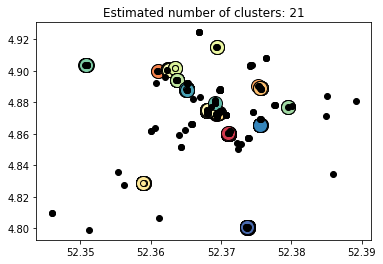

In [12]:
#visualize clusters
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_clusters_1 = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (cluster_labels == k)

    xy = coords[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = coords[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_1)
plt.show()

In [13]:
#merge met de rest van de gegevens en verander geen NaN clusters naar -1
df = df[["VgNr", "cluster"]]
df = pd.merge(df_old, df, on="VgNr", how="left")
df["cluster"] = df["cluster"].fillna(-1)

In [16]:
#Clusters naar middelste XY
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters = clusters[:-1]

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

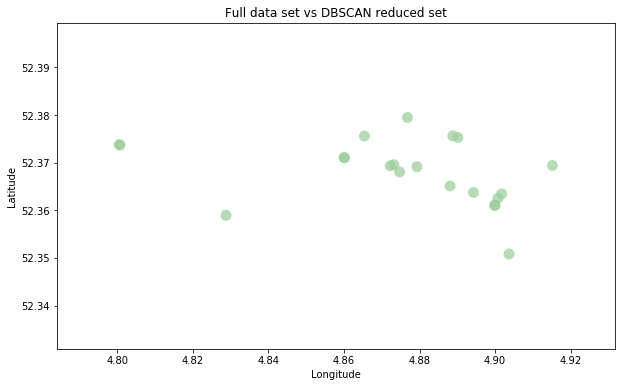

In [17]:
#Scatterplot van stoplocaties
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()